In [156]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from lib.Utility import exportExcelWithTimeStamp

from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
import plotly.express as px
from plotly import graph_objects as go
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# features = ['B365H','B365D', 'B365A',	'B365<2.5']
features = ['HomeGoalsCumulative', 'AwayGoalsCumulative', 'HomePointsCumulative','AwayPointsCumulative', 'HomeGoalsConcededCumulative',	'AwayGoalsConcededCumulative'
            #  , 'B365D'
            #  , 'B365H'
            # , 'B365A'
            # , 'B365>2.5'
            ]
# features = ['HomeGoalsCumulative', 'AwayGoalsCumulative', 'AwayPointsCumulative', 'HomeGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'AwayGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'HomePointsCumulative']

threshold = 0.2

In [157]:
data = pd.read_excel('data/merged.xlsx')
# data = pd.read_excel('data/engdata/24-25.xlsx')
# data = pd.read_excel('data/mergedDataSerieB.xlsx')
# data['Cluster'] = np.where(data['FTR'] == 'H', 1, np.where(data['FTR'] == 'A', 2, 0))
data['Cluster'] = np.where(data['FTHG'] == data['FTAG'], 1, 0) #data['FTR'].map({'D': 0, 'H': 1, 'A': 2}) 
# data = data[data['HomeGoalsCumulative'].notna()]
# data = data[data['AwayGoalsCumulative'].notna()]
# data = data[data['HomePointsCumulative'].notna()]
# data = data[data['AwayPointsCumulative'].notna()]
# data = data[data['HomeGoalsConcededCumulative'].notna()]
# data = data[data['AwayGoalsConcededCumulative'].notna()]
data = data[data['B365D'].notna()]
# data = data[data['B365H']>1.6]
# data.dropna()
data.tail()

,Date,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgCAHH,AvgCAHA,HomeGoalsCumulative,AwayGoalsCumulative,HomePointsCumulative,AwayPointsCumulative,HomeGoalsConcededCumulative,AwayGoalsConcededCumulative,MatchGoal,Cluster
3795,1970-01-01 01:00:45.422,I2,19:30:00,FeralpiSalo,Ternana,0,1,A,0.0,1.0,...,1.91,1.91,44,42,33,40,64,50,1,0
3796,1970-01-01 01:00:45.422,I2,19:30:00,Lecco,Modena,2,3,A,1.0,3.0,...,1.86,1.94,33,38,26,44,71,45,5,0
3797,1970-01-01 01:00:45.422,I2,19:30:00,Reggiana,Parma,1,1,D,1.0,0.0,...,2.07,1.76,37,65,46,75,44,34,2,1
3798,1970-01-01 01:00:45.422,I2,19:30:00,Spezia,Venezia,2,1,H,0.0,1.0,...,1.94,1.87,34,68,41,70,48,44,3,0
3799,1970-01-01 01:00:45.422,I2,19:30:00,Sudtirol,Palermo,0,1,A,0.0,0.0,...,1.83,1.98,46,61,47,53,47,53,1,0


In [158]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 42,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()

print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')


X_train: (2646, 6) 
X_test: (1135, 6) 
y_train: (2646,) 
y_test: (1135,)


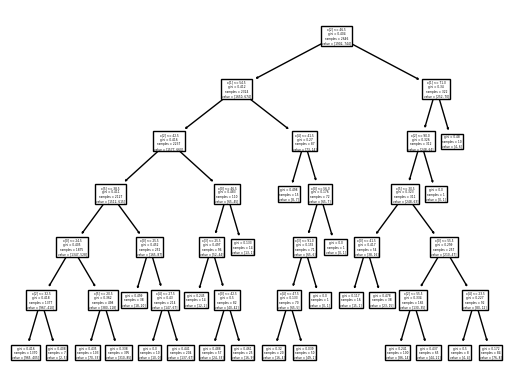

In [159]:

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
# model = LogisticRegression(C=1/reg, multi_class='ovr',solver="liblinear", random_state=42).fit(x_train, y_train)

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=100, random_state=42).fit(x_train, y_train)
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42, min_samples_split = 50
                            #    , class_weight='balanced'
                            , max_depth= 6
                               ).fit(x_train, y_train)
from sklearn import tree
tree.plot_tree(model)
plt.show()
# joblib.dump(model, "./Soccer-ml1.joblib")

# model = joblib.load("Soccer-ml3.joblib")

In [160]:
def custom_predict(X, threshold):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)
# Definisci una funzione che applica la logica descritta
def calculate_gain(row, quota_minima):
    
    if(row['predictions'] > threshold):
        if row['Cluster'] == row['predictions']:
            if row['predictions'] == 1 and row['B365H'] > quota_minima:
                return row['B365H']-1
            elif row['predictions'] == 2 and row['B365A'] > quota_minima:
                return row['B365A']-1
            elif row['predictions'] == 0 and row['B365D'] > quota_minima:
                return row['B365D']-1
        else:
            if((row['predictions'] == 0 and row['B365D'] > quota_minima) or (row['predictions'] == 2 and row['B365A'] > quota_minima) or (row['predictions'] == 1 and row['B365H'] > quota_minima)):
                return -1

In [161]:
# x_test = data[features]
# y_test = data['Cluster']

df = x_test.copy()
# df['predictions'] = model.predict(x_test.sort_index())
df['predictions'] = custom_predict(x_test.sort_index(), threshold)
pred_prob = model.predict_proba(x_test.sort_index())

df2 = pd.DataFrame(pred_prob)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)

finalDataset = data[data.index.isin(x_test.index)]
finalDataset['predictions'] = df['predictions']
finalDataset['pred_prob'] = df[1]
# finalDataset['gain'] = finalDataset.apply(calculate_gain, axis=1, args=(1.9,))
finalDataset['gain'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['predictions'] > threshold),
                                finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['predictions'] > threshold), -1, None))

equity = finalDataset['gain'].sum()
print("Equity", equity)

print(f"Accuracy score: {round(100*accuracy_score(y_test, df['predictions']),2)}%")
exportExcelWithTimeStamp(finalDataset, "Dataframe/", "df.xlsx")

C:\Users\vitto\AppData\Local\Temp\ipykernel_17684\3372964952.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDataset['predictions'] = df['predictions']
C:\Users\vitto\AppData\Local\Temp\ipykernel_17684\3372964952.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDataset['pred_prob'] = df[1]
C:\Users\vitto\AppData\Local\Temp\ipykernel_17684\3372964952.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Equity 68.61
Accuracy score: 35.86%


In [162]:
joblib.dump(model, "./Soccer-ml4.joblib")

['./Soccer-ml4.joblib']